<a href="https://colab.research.google.com/github/lukriste/Baigiamasis/blob/lenteles_tvarkymas/Modelio_mt5_treniravimas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paruošimas

In [81]:
from google.colab import files
uploaded = files.upload()

Saving naujas_gnm.xlsx to naujas_gnm (2).xlsx


In [82]:
df = pd.read_excel("naujas_gnm.xlsx")

In [83]:
import pandas as pd
from sqlalchemy import create_engine
import re

In [84]:

df = df.rename(columns={
    "Siptomas": "simptomas",
    "Input/situacija": "ivestis",
    "Output/GNM_interpretacija": "isvestis"
})

def normalizuoti_teksta(tekstas):
    if pd.isna(tekstas):
        return ""
    tekstas = str(tekstas).strip()
    if tekstas.startswith('"') and tekstas.endswith('"'):
        tekstas = tekstas[1:-1]
    tekstas = tekstas.replace("“", '"').replace("”", '"').replace("„", '"')
    tekstas = tekstas.replace("‘", "'").replace("’", "'")
    tekstas = tekstas.replace("–", "-").replace("—", "-")
    tekstas = tekstas.replace("\\", "/")

    if tekstas.startswith('"'):
        tekstas = tekstas[1:]
    if tekstas.endswith('"'):
        tekstas = tekstas[:-1]

    tekstas = re.sub(r"[\r\n\t]", " ", tekstas)
    tekstas = re.sub(r"\s{2,}", " ", tekstas)
    tekstas = re.sub(r"\s+([.,;!?()])", r"\1", tekstas)
    return tekstas

df["simptomas"] = df["simptomas"].apply(lambda x: normalizuoti_teksta(x).lower())
df["ivestis"] = df["ivestis"].apply(lambda x: normalizuoti_teksta(x).lower())
df["isvestis"] = df["isvestis"].apply(normalizuoti_teksta)

df["ivestis"] = "simptomas: " + df["simptomas"] + ". " + df["ivestis"]

In [85]:
!pip install transformers datasets sentencepiece

In [47]:
!pip install openpyxl pymysql sqlalchemy

In [86]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

Tokenizavimo funkcija

In [87]:
from transformers import MT5Tokenizer, TFT5ForConditionalGeneration
model_name = "google/mt5-small"
tokenizer = MT5Tokenizer.from_pretrained(model_name)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


In [88]:
def tokenize_function(example):
    input_enc = tokenizer(example["ivestis"], padding="max_length", truncation=True, max_length=128)
    output_enc = tokenizer(example["isvestis"], padding="max_length", truncation=True, max_length=128)
    input_enc["labels"] = output_enc["input_ids"]
    return input_enc

train_tokenized = train_dataset.map(tokenize_function)
test_tokenized = test_dataset.map(tokenize_function)


Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

TF dataset paruošimas

In [89]:
train_set = train_tokenized.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["labels"],
    shuffle=True,
    batch_size=8,
)

val_set = test_tokenized.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=8,
)


/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


 Modelio treniravimas

In [90]:
model = TFT5ForConditionalGeneration.from_pretrained(model_name)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))
history = model.fit(train_set, validation_data=val_set, epochs=100)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


tf_model.h5:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at google/mt5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch 1/100
12/12 [==============================] - 59s 1000ms/step - loss: 41.9455 - val_loss: 37.3969
Epoch 2/100
12/12 [==============================] - 6s 476ms/step - loss: 38.3539 - val_loss: 32.1772
Epoch 3/100
12/12 [==============================] - 6s 525ms/step - loss: 36.1622 - val_loss: 29.3729
Epoch 4/100
12/12 [==============================] - 6s 487ms/step - loss: 34.5944 - val_loss: 27.6669
Epoch 5/100
12/12 [==============================] - 6s 472ms/step - loss: 32.8668 - val_loss: 26.4035
Epoch 6/100
12/12 [==============================] - 6s 453ms/step - loss: 30.4914 - val_loss: 24.0054
Epoch 7/100
12/12 [==============================] - 6s 486ms/step - loss: 28.7853 - val_loss: 23.0278
Epoch 8/100
12/12 [==============================] - 5s 441ms/step - loss: 27.8253 - val_loss: 23.2691
Epoch 9/100
12/12 [==============================] - 5s 443ms/step - loss: 26.3644 - val_loss: 22.0476
Epoch 10/100
12/12 [==============================] - 6s 480ms/step - l

Treniravimo grafikas

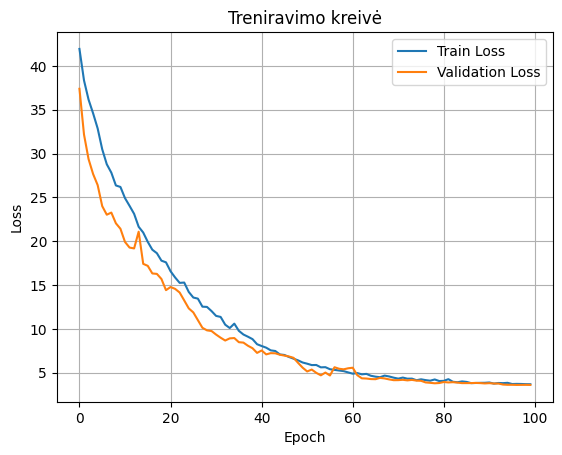

In [91]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Treniravimo kreivė")
plt.legend()
plt.grid(True)
plt.show()

 8. Modelio testavimas

In [99]:
def test_ivestis(ivestis):
    input_ids = tokenizer(ivestis, return_tensors="tf", truncation=True, padding=True, max_length=128).input_ids
    output_ids = model.generate(
        input_ids,
        max_length=128,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
        repetition_penalty=2.0,
        eos_token_id=tokenizer.eos_token_id,
        decoder_start_token_id=0
    )
    isvestis = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Įvestis: {ivestis}")
    print(f"Išvestis: {isvestis}")
    return isvestis

def suformatuoti_ivesti(simptomas, situacija):
    return f"Simptomas: {simptomas}.\nSituacija: {situacija}\nKlausimas: Paaiškink pagal GNM."

ivestis = suformatuoti_ivesti("skausmas nugaroje", "Vyras patiria ilgalaikę įtampą darbe")
test_ivestis(ivestis)

Įvestis: Simptomas: skausmas nugaroje.
Situacija: Vyras patiria ilgalaikę įtampą darbe
Klausimas: Paaiškink pagal GNM.
Išvestis: <extra_id_0>NM.reiškia susisą su GNM tai paios ar būt u atsimuisti po, galiti


'<extra_id_0>NM.reiškia susisą su GNM tai paios ar būt u atsimuisti po, galiti'